In [2]:
%cd /home/hotson/kaggle_work/recodai-luc-scientific-image-forgery-detection/code/

/home/hotson/kaggle_work/recodai-luc-scientific-image-forgery-detection/code


# Modules

In [1]:
import cv2
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple
from matplotlib import pyplot as plt
import os
import torch
import requests

from PIL import Image
from transformers import AutoModelForObjectDetection, AutoImageProcessor
from ultralytics import YOLO


/home/hotson/kaggle_work/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
img_path = "../supplemental_images/1712.png"

# Method 1

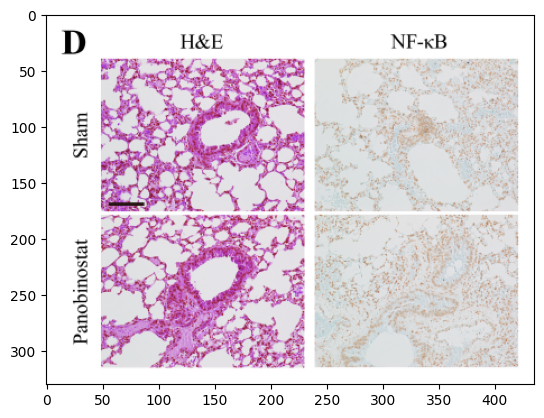

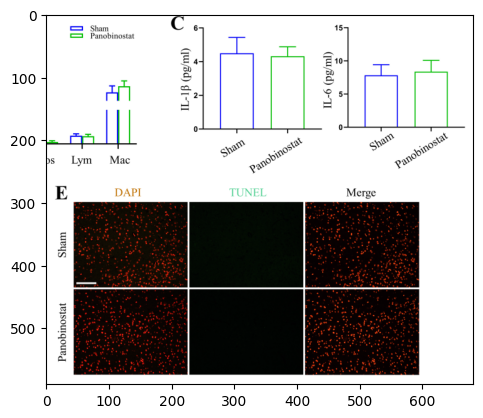

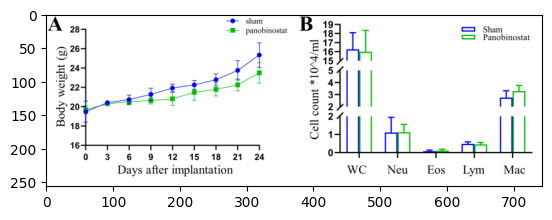

In [ ]:
def extract_panels(image_path):
    # Load the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Use thresholding to highlight the panels
    # We invert it so the panels are white and the background is black
    _, thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)

    # Dilate the image to bridge gaps between labels and the charts
    # This ensures the "A" label and the "Graph" are seen as one panel
    kernel = np.ones((15, 15), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations=2)

    # Find contours (the outlines of the panels)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    panel_count = 0
    panels = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # Filter out very small boxes (noise/tiny text)
        if w > 100 and h > 100:
            panel_count += 1
            panel = image[y:y+h, x:x+w]
            panels.append(panel)
    return panels

# Run the function
panels = extract_panels(img_path)

for panel in panels:
    plt.imshow(panel);
    plt.show()



# Method 2

In [22]:
@dataclass
class Panel:
    bbox: Tuple[int, int, int, int]   # (x1,y1,x2,y2)
    method: str
    score: float
    panel_id: int


def clip_bbox(x1: int, y1: int, x2: int, y2: int, W: int, H: int) -> Tuple[int, int, int, int]:
    x1 = max(0, min(W - 1, x1))
    y1 = max(0, min(H - 1, y1))
    x2 = max(1, min(W, x2))
    y2 = max(1, min(H, y2))
    if x2 <= x1 + 1:
        x2 = min(W, x1 + 2)
    if y2 <= y1 + 1:
        y2 = min(H, y1 + 2)
    return x1, y1, x2, y2


def iou(a: Tuple[int,int,int,int], b: Tuple[int,int,int,int]) -> float:
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
    inter = iw * ih
    if inter <= 0:
        return 0.0
    area_a = (ax2 - ax1) * (ay2 - ay1)
    area_b = (bx2 - bx1) * (by2 - by1)
    return inter / max(1e-9, (area_a + area_b - inter))


def smooth_1d(x: np.ndarray, k: int) -> np.ndarray:
    """Moving average smoothing (no scipy)."""
    if k <= 1:
        return x
    k = int(k)
    if k % 2 == 0:
        k += 1
    pad = k // 2
    xp = np.pad(x, (pad, pad), mode="edge")
    kernel = np.ones(k, dtype=np.float32) / k
    return np.convolve(xp, kernel, mode="valid")


def find_valley_runs(profile: np.ndarray, thresh: float, min_width: int) -> List[Tuple[int, int]]:
    """Contiguous ranges where profile < thresh. Returns (start,end) end-exclusive."""
    runs = []
    start = None
    for i, v in enumerate(profile):
        if v < thresh:
            if start is None:
                start = i
        else:
            if start is not None and i - start >= min_width:
                runs.append((start, i))
            start = None
    if start is not None and len(profile) - start >= min_width:
        runs.append((start, len(profile)))
    return runs


def cuts_from_runs(runs: List[Tuple[int, int]], max_len: int, min_gap: int = 10) -> List[int]:
    """Convert separator runs to cut positions (run midpoints), include 0 and max_len."""
    cuts = [0]
    for s, e in runs:
        cuts.append((s + e) // 2)
    cuts.append(max_len)
    cuts = sorted(set(int(c) for c in cuts))

    cleaned = [cuts[0]]
    for c in cuts[1:]:
        if c - cleaned[-1] >= min_gap:
            cleaned.append(c)
    if cleaned[-1] != max_len:
        cleaned.append(max_len)
    return cleaned


def extract_panels_by_projection(
    img_bgr: np.ndarray,
    min_panel_size: int = 96,
    smooth_k: int = 41,
    sep_percentile: float = 12.0,
    min_sep_width: int = 10,
    border_margin: int = 2,
) -> List[Panel]:
    """
    Find row/col separator bands via projection profiles.
    Tries both: dark separators (low) and bright separators (high).
    """
    H, W = img_bgr.shape[:2]
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    col_prof = gray.mean(axis=0).astype(np.float32)
    row_prof = gray.mean(axis=1).astype(np.float32)

    col_s = smooth_1d(col_prof, smooth_k)
    row_s = smooth_1d(row_prof, smooth_k)

    def propose_cuts_low(profile_s: np.ndarray) -> List[int]:
        thr = np.percentile(profile_s, sep_percentile)
        runs = find_valley_runs(profile_s, thr, min_sep_width)
        return cuts_from_runs(runs, len(profile_s))

    def propose_cuts_high(profile_s: np.ndarray) -> List[int]:
        thr = np.percentile(profile_s, 100.0 - sep_percentile)
        runs = []
        start = None
        for i, v in enumerate(profile_s):
            if v > thr:
                if start is None:
                    start = i
            else:
                if start is not None and i - start >= min_sep_width:
                    runs.append((start, i))
                start = None
        if start is not None and len(profile_s) - start >= min_sep_width:
            runs.append((start, len(profile_s)))
        return cuts_from_runs(runs, len(profile_s))

    candidates = []
    for mode in ["low", "high"]:
        if mode == "low":
            x_cuts = propose_cuts_low(col_s)
            y_cuts = propose_cuts_low(row_s)
        else:
            x_cuts = propose_cuts_high(col_s)
            y_cuts = propose_cuts_high(row_s)

        nx, ny = len(x_cuts) - 1, len(y_cuts) - 1
        if nx * ny <= 1:
            continue

        valid = 0
        area_fracs = []
        for y1, y2 in zip(y_cuts[:-1], y_cuts[1:]):
            for x1, x2 in zip(x_cuts[:-1], x_cuts[1:]):
                w, h = x2 - x1, y2 - y1
                if w >= min_panel_size and h >= min_panel_size:
                    valid += 1
                    area_fracs.append((w * h) / (W * H))
        if valid == 0:
            continue

        score = float(np.mean(area_fracs) * np.log(1 + valid))
        candidates.append((score, mode, x_cuts, y_cuts))

    if not candidates:
        return []

    candidates.sort(key=lambda t: t[0], reverse=True)
    best_score, best_mode, x_cuts, y_cuts = candidates[0]

    panels: List[Panel] = []
    pid = 0
    for y1, y2 in zip(y_cuts[:-1], y_cuts[1:]):
        for x1, x2 in zip(x_cuts[:-1], x_cuts[1:]):
            w, h = x2 - x1, y2 - y1
            if w < min_panel_size or h < min_panel_size:
                continue
            x1m, y1m, x2m, y2m = x1 + border_margin, y1 + border_margin, x2 - border_margin, y2 - border_margin
            x1m, y1m, x2m, y2m = clip_bbox(x1m, y1m, x2m, y2m, W, H)
            if (x2m - x1m) < min_panel_size or (y2m - y1m) < min_panel_size:
                continue
            pid += 1
            area_frac = ((x2m - x1m) * (y2m - y1m)) / (W * H)
            panels.append(Panel((x1m, y1m, x2m, y2m), method=f"proj_grid_{best_mode}", score=float(area_frac), panel_id=pid))

    # Filter out "pure background" rectangles via edge density
    if panels:
        edges = cv2.Canny(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY), 50, 150)
        kept = []
        for p in panels:
            x1, y1, x2, y2 = p.bbox
            roi = edges[y1:y2, x1:x2]
            edge_ratio = roi.mean() / 255.0
            if edge_ratio < 0.002:
                continue
            kept.append(p)
        panels = kept or panels

    return panels


def extract_panels_by_components(
    img_bgr: np.ndarray,
    min_panel_size: int = 96,
    min_area_frac: float = 0.01,
    merge_iou_thresh: float = 0.3,
) -> List[Panel]:
    """
    Fallback: find "content blobs" via gradient magnitude and CC bounding boxes.
    """
    H, W = img_bgr.shape[:2]
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    mag = cv2.magnitude(gx, gy)
    mag = cv2.GaussianBlur(mag, (5, 5), 0)

    thr = np.percentile(mag, 85)
    binm = (mag >= thr).astype(np.uint8) * 255

    k = max(3, int(min(H, W) * 0.01))
    if k % 2 == 0:
        k += 1
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k, k))
    binm = cv2.morphologyEx(binm, cv2.MORPH_CLOSE, kernel, iterations=1)
    binm = cv2.dilate(binm, kernel, iterations=1)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(binm, connectivity=8)

    boxes = []
    for i in range(1, num):
        x, y, w, h, area = stats[i]
        if w < min_panel_size or h < min_panel_size:
            continue
        if (w * h) / (W * H) < min_area_frac:
            continue
        boxes.append((x, y, x + w, y + h))

    # Merge overlapping boxes
    merged: List[Tuple[int,int,int,int]] = []
    for b in sorted(boxes, key=lambda t: (t[2]-t[0])*(t[3]-t[1]), reverse=True):
        if all(iou(b, m) < merge_iou_thresh for m in merged):
            merged.append(b)

    panels: List[Panel] = []
    for pid, b in enumerate(merged, start=1):
        x1, y1, x2, y2 = clip_bbox(*b, W, H)
        area_frac = ((x2-x1)*(y2-y1)) / (W*H)
        panels.append(Panel((x1,y1,x2,y2), method="cc_content", score=float(area_frac), panel_id=pid))

    return panels


def extract_panels(img_bgr: np.ndarray, min_panel_size: int = 96) -> List[Panel]:
    """
    Main: projection grid -> CC fallback -> full image fallback.
    """
    panels = extract_panels_by_projection(img_bgr, min_panel_size=min_panel_size)

    # If projections fail or return just 1 panel, try CC fallback
    if not panels or len(panels) == 1:
        cc = extract_panels_by_components(img_bgr, min_panel_size=min_panel_size)
        if len(cc) >= 2:
            panels = cc

    if not panels:
        H, W = img_bgr.shape[:2]
        panels = [Panel((0, 0, W, H), method="full", score=1.0, panel_id=1)]

    # Renumber
    for i, p in enumerate(panels, start=1):
        p.panel_id = i
    return panels


def draw_panels(img_bgr: np.ndarray, panels: List[Panel]) -> np.ndarray:
    out = img_bgr.copy()
    for p in panels:
        x1, y1, x2, y2 = p.bbox
        cv2.rectangle(out, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(out, f"{p.panel_id}:{p.method}", (x1, max(0, y1-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
    return out


num panels: 2
Panel(bbox=(91, 2, 558, 711), method='proj_grid_high', score=0.3665194034344693, panel_id=1)
Panel(bbox=(562, 2, 1231, 711), method='proj_grid_high', score=0.5250567042776445, panel_id=2)


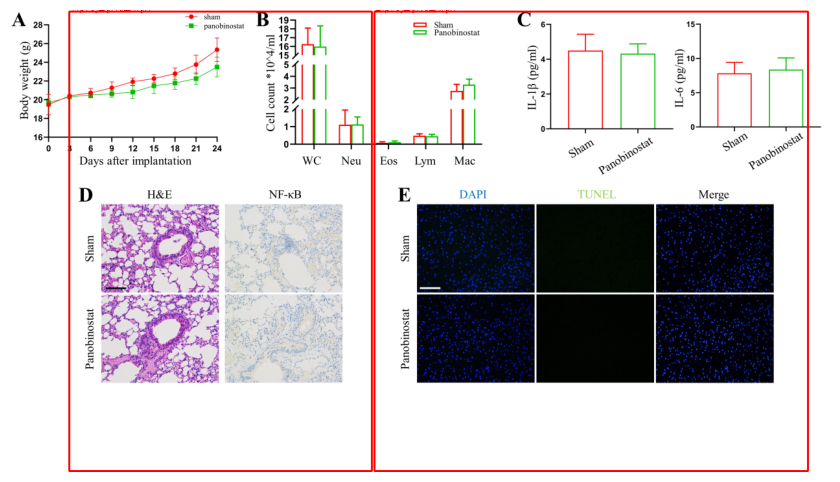

In [23]:
img = cv2.imread(img_path)
panels = extract_panels(img, min_panel_size=96)

print("num panels:", len(panels))
for p in panels:
    print(p)

overlay = draw_panels(img, panels)
# show overlay in notebook
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Method 3

In [26]:
image_processor = AutoImageProcessor.from_pretrained("IDEA-Research/dab-detr-resnet-50")
model = AutoModelForObjectDetection.from_pretrained("IDEA-Research/dab-detr-resnet-50")

/home/hotson/kaggle_work/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/hotson/kaggle_work/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/hotson/kaggle_work/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter 

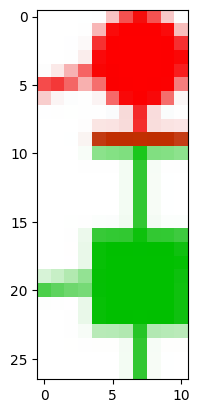

traffic light: 0.61 [182.0, 106.53, 193.46, 133.97]


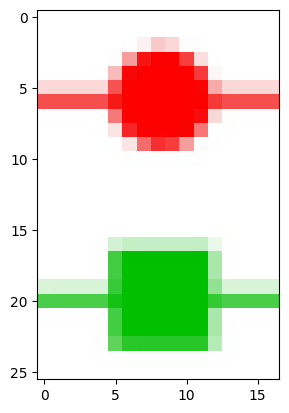

traffic light: 0.59 [270.82, 4.41, 287.84, 30.28]


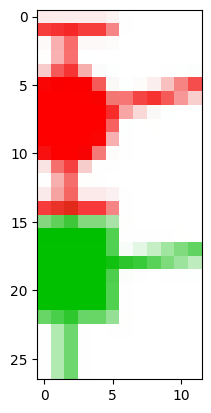

traffic light: 0.52 [220.46, 97.9, 232.02, 124.53]


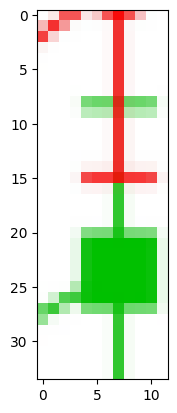

traffic light: 0.50 [312.14, 64.37, 323.53, 98.46]


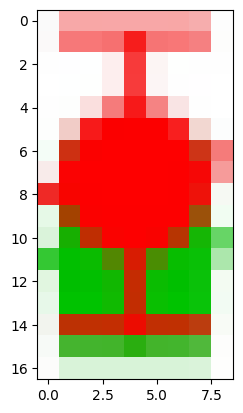

traffic light: 0.48 [119.91, 119.58, 128.86, 137.09]


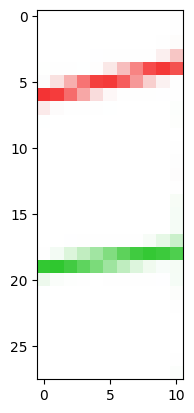

traffic light: 0.35 [239.59, 95.49, 250.87, 122.58]


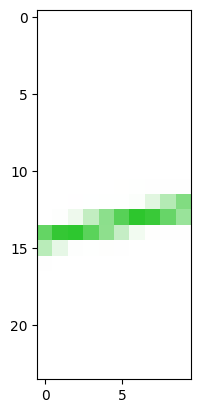

traffic light: 0.34 [267.77, 94.6, 278.49, 119.07]


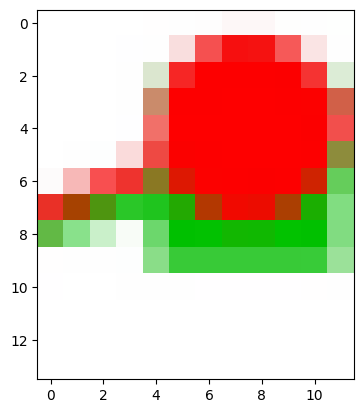

traffic light: 0.33 [83.82, 127.64, 96.06, 142.12]


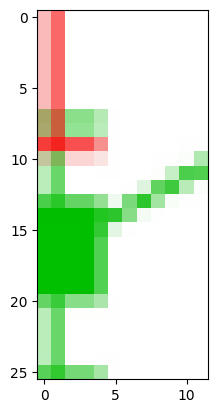

traffic light: 0.33 [286.5, 89.36, 298.19, 115.21]


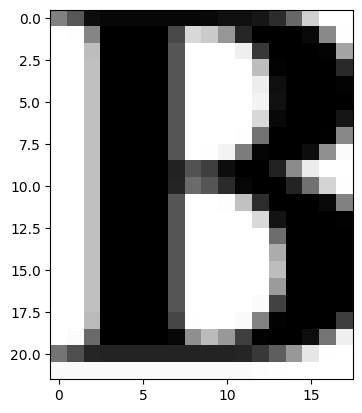

traffic light: 0.31 [380.03, 4.26, 398.15, 26.29]


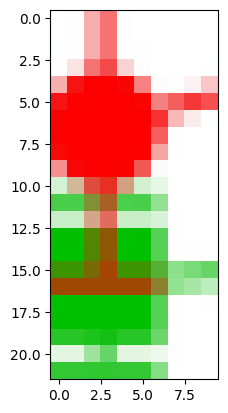

traffic light: 0.30 [153.53, 112.88, 163.8, 135.07]


In [29]:
image = Image.open(img_path).convert("RGB")
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

results = image_processor.post_process_object_detection(outputs, target_sizes=torch.tensor([image.size[::-1]]), threshold=0.3)

for result in results:
    for score, label_id, box in zip(result["scores"], result["labels"], result["boxes"]):
        score, label = score.item(), label_id.item()
        box = [round(i, 2) for i in box.tolist()]
        cropped_img = image.crop(box)

        plt.imshow(cropped_img);
        plt.show();
        print(f"{model.config.id2label[label]}: {score:.2f} {box}")

# Method 4

In [4]:
model = YOLO("../runs/detect/train/weights/best.pt")

In [ ]:
res = res = model.predict(img_path, conf=0.25, iou=0.6, imgsz=1024)
res


image 1/1 /home/hotson/kaggle_work/recodai-luc-scientific-image-forgery-detection/code/../supplemental_images/1712.png: 576x1024 62 panels, 13.1ms
Speed: 4.8ms preprocess, 13.1ms inference, 18.2ms postprocess per image at shape (1, 3, 576, 1024)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'panel'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255,